In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import geopandas as gpd
from shapely.geometry import Point
import cartopy.crs as ccrs
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.metrics import f1_score, precision_score, recall_score, precision_recall_curve, average_precision_score
from stable_baselines3 import DQN
from stable_baselines3.common.env_checker import check_env
import gymnasium as gym
import random
from gymnasium import spaces

In [3]:
file_path = 'zip://clustered_data_4months.zip!clustered_data_4months (2).geojson'
data = gpd.read_file(file_path, driver="GeoJSON")

# Convert 'time' to datetime and sort by time
data['time'] = pd.to_datetime(data['time'])
data = data.sort_values('time').reset_index(drop=True)

# Create time_step as an ordinal index 
data['time_step'] = data.index

/Users/shashwatraj/Documents/GitHub/Code-Lab_RL_PriorityObs/tatcenv/lib/python3.13/site-packages/pyogrio/raw.py:198: RuntimeWarning: driver GeoJSON does not support open option DRIVER
  return ogr_read(


In [4]:
world = gpd.read_file('110m_cultural.zip', layer='ne_110m_admin_0_boundary_lines_land')
geometry = [Point(xy) for xy in zip(data['lon_sat'], data['lat_sat'])]
geo_full = gpd.GeoDataFrame(data, geometry=geometry)
geo_full['ground_track'] = geo_full.apply(lambda row: 0 if world.contains(row.geometry).any() else 1, axis=1)
data['ground_track'] = geo_full['ground_track']

In [5]:
data['lat_rad'] = np.radians(data['lat_sat'])
data['lon_rad'] = np.radians(data['lon_sat'])
data['x'] = np.cos(data['lat_rad']) * np.cos(data['lon_rad'])
data['y'] = np.cos(data['lat_rad']) * np.sin(data['lon_rad'])
data['z'] = np.sin(data['lat_rad'])

In [6]:
scaler = MinMaxScaler()
cols_to_scale = ['x', 'y', 'z', 'cnprcp_mean']
scaled_values = scaler.fit_transform(data[cols_to_scale])
data['x_norm'] = scaled_values[:, 0]
data['y_norm'] = scaled_values[:, 1]
data['z_norm'] = scaled_values[:, 2]
data['cnprcp_norm'] = scaled_values[:, 3]

In [7]:
def compute_orbit_ids(df, lon_threshold=358):
    
    df = df.copy()
    orbit_id = 0
    orbit_ids = [orbit_id]
    prev_lon = df.iloc[0]['lon_sat']
    for idx in range(1, len(df)):
        curr_lon = df.iloc[idx]['lon_sat']
        # Handle wrap-around: e.g., near 180 and -180 are close
        diff = abs(curr_lon - prev_lon)
        if diff > lon_threshold:
            orbit_id += 1
        orbit_ids.append(orbit_id)
        prev_lon = curr_lon
    df['orbit_id'] = orbit_ids
    return df

data = compute_orbit_ids(data, lon_threshold=300)

print("Number of orbits found:", data['orbit_id'].nunique())

Number of orbits found: 1448


In [8]:
class SatelliteOrbitEnv(gym.Env):
    def __init__(self, df, alpha=1.0, gamma=1.0, mu=1.0):
        super(SatelliteOrbitEnv, self).__init__()
        self.full_df = df.reset_index(drop=True)
        self.alpha = alpha
        self.gamma = gamma
        self.mu = mu

        self.action_space = spaces.Discrete(2)

        # Determine one-hot encoded time_range columns.
        self.one_hot_cols = [col for col in df.columns if col.startswith('time_range_')]
        self.n_one_hot = len(self.one_hot_cols)
        # Observation space: continuous features [x_norm, y_norm, z_norm, ground_track] (4 dims)
        # plus one-hot encoded time_range (n_one_hot dims)
        self.obs_dim = 4 + self.n_one_hot
        self.observation_space = spaces.Box(low=0.0, high=1.0, shape=(self.obs_dim,), dtype=np.float32)

        # Prepare episodes: group by orbit_id
        self.episodes = [group for _, group in self.full_df.groupby('orbit_id')]
        self.current_episode = None
        self._index = 0

    def reset(self, seed=None, options=None):
        # Randomly select an orbit cycle (episode)
        self.current_episode = random.choice(self.episodes).reset_index(drop=True)
        self._index = 0
        return self._get_obs(), {}

    def step(self, action):
        reward = self._compute_reward(action)
        self._index += 1
        done = self._index >= len(self.current_episode) - 1
        obs = self._get_obs() if not done else np.zeros(self.obs_dim, dtype=np.float32)
        terminated = done
        truncated = False
        return obs, reward, terminated, truncated, {}

    def _get_obs(self):
        row = self.current_episode.iloc[self._index]
        # Continuous features: x_norm, y_norm, z_norm, ground_track.
        cont_features = np.array([
            row['x_norm'],
            row['y_norm'],
            row['z_norm'],
            float(row['ground_track'])
        ], dtype=np.float32)
        one_hot_features = row[self.one_hot_cols].values.astype(np.float32)
        return np.concatenate([cont_features, one_hot_features])
    
    def _compute_reward(self, action):
        row = self.current_episode.iloc[self._index]
        cnprcp_mean = row['cnprcp_mean']
        scale = 10000  # scaling factor to amplify small precipitation values
        if action == 1:
            if cnprcp_mean > 0:
                # Correct detection: give a base reward of 1 plus bonus proportional to intensity.
                reward = 1 + (cnprcp_mean * scale)
            else:
                # False positive: a small penalty for acting when there's no precipitation.
                reward = -0.1
        else:  # action == 0
            if cnprcp_mean > 0:
                reward = -0.01
            else:
                reward = 0
        return reward
    

In [9]:
all_f1_scores = []
all_rewards = []
all_episode_results = []
all_precision_scores = []
all_recall_scores = []

env = SatelliteOrbitEnv(data, alpha=1.0, gamma=1.0, mu=1.0)
check_env(env, warn=True)

model = DQN("MlpPolicy", env, verbose=0)
model.learn(total_timesteps=100000)

n_eval_episodes = 50
eval_rewards = []

for i in range(n_eval_episodes):
    obs, _ = env.reset()
    done = False
    ep_reward = 0.0
    preds = []
    acts = []
    lats = []
    lons = []
    
    while not done:
        action, _ = model.predict(obs, deterministic=True)
        preds.append(action)
        
        # Extract current observation details from the environment.
        current_row = env.current_episode.iloc[env._index]
        current_cprcp = current_row['cnprcp_mean']
        act = 1 if current_cprcp > 0 else 0
        acts.append(act)
        
        lats.append(current_row['lat_sat'])
        lons.append(current_row['lon_sat'])
        
        obs, reward, terminated, truncated, info = env.step(action)
        ep_reward += reward
        done = terminated or truncated
        
    eval_rewards.append(ep_reward)
    f1 = f1_score(acts, preds, zero_division=0)
    precision = precision_score(acts, preds, zero_division=0)
    recall = recall_score(acts, preds, zero_division=0)
    all_precision_scores.append(precision)
    all_recall_scores.append(recall)
    all_f1_scores.append(f1)
    print(f"Episode {i}: F1 = {f1:.3f}, Precision = {precision:.3f}, Recall = {recall:.3f}, Reward = {ep_reward:.3f}")
    
    # Record results for the current episode.
    all_episode_results.append({
        "actual": acts,
        "predicted": preds,
        "lat": lats,
        "lon": lons,
    })

mean_f1 = np.mean(all_f1_scores)
mean_reward = np.mean(eval_rewards)
mean_precision = np.mean(all_precision_scores)
mean_recall = np.mean(all_recall_scores)
print(f"\nOverall: Mean F1 = {mean_f1:.3f}, Mean Precision = {mean_precision:.3f}, Mean Recall = {mean_recall:.3f}, Mean Reward per Episode = {mean_reward:.3f}")
print("Number of episodes recorded:", len(all_episode_results))

Episode 0: F1 = 0.345, Precision = 0.217, Recall = 0.833, Reward = 5.609
Episode 1: F1 = 0.182, Precision = 0.111, Recall = 0.500, Reward = 1.236
Episode 2: F1 = 0.000, Precision = 0.000, Recall = 0.000, Reward = -1.400
Episode 3: F1 = 0.000, Precision = 0.000, Recall = 0.000, Reward = -1.210
Episode 4: F1 = 0.000, Precision = 0.000, Recall = 0.000, Reward = -0.500
Episode 5: F1 = 0.235, Precision = 0.133, Recall = 1.000, Reward = 1.466
Episode 6: F1 = 0.000, Precision = 0.000, Recall = 0.000, Reward = -0.400
Episode 7: F1 = 0.250, Precision = 0.143, Recall = 1.000, Reward = 1.501
Episode 8: F1 = 0.000, Precision = 0.000, Recall = 0.000, Reward = -0.410
Episode 9: F1 = 0.316, Precision = 0.188, Recall = 1.000, Reward = 2.437
Episode 10: F1 = 0.000, Precision = 0.000, Recall = 0.000, Reward = -2.000
Episode 11: F1 = 0.000, Precision = 0.000, Recall = 0.000, Reward = -2.600
Episode 12: F1 = 0.333, Precision = 0.200, Recall = 1.000, Reward = 2.395
Episode 13: F1 = 0.000, Precision = 0.000

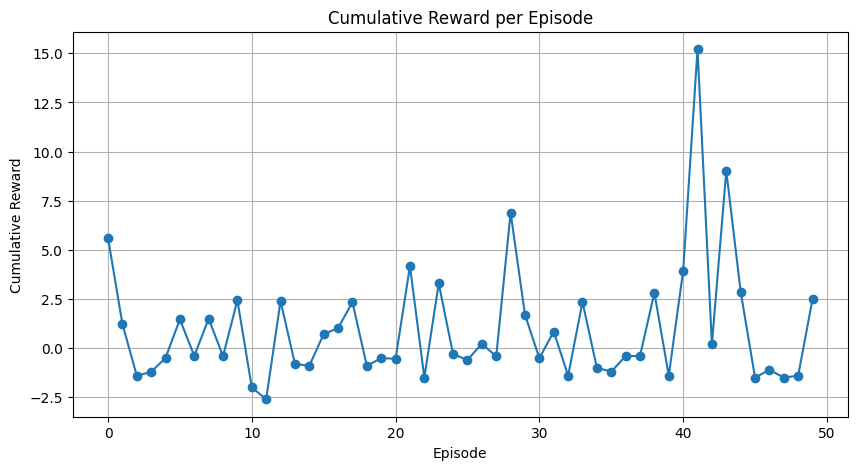

In [13]:
from sklearn.metrics import precision_recall_curve, average_precision_score

plt.figure(figsize=(10, 5))
plt.plot(eval_rewards, marker='o', linestyle='-')
plt.xlabel("Episode")
plt.ylabel("Cumulative Reward")
plt.title("Cumulative Reward per Episode")
plt.grid(True)
plt.show()

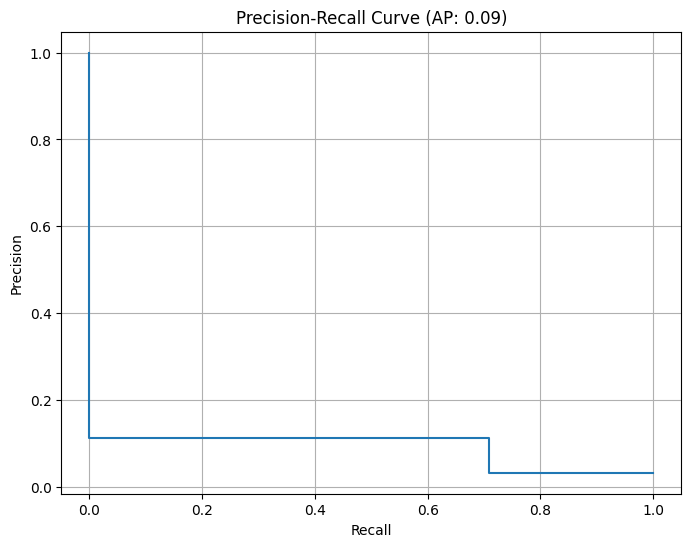

In [12]:
all_actual = []
all_predicted = []
for result in all_episode_results:
    all_actual.extend(result["actual"])
    all_predicted.extend(result["predicted"])

precision, recall, thresholds = precision_recall_curve(all_actual, all_predicted)
avg_precision = average_precision_score(all_actual, all_predicted)

plt.figure(figsize=(8, 6))
plt.step(recall, precision, where='post')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title(f"Precision-Recall Curve (AP: {avg_precision:.2f})")
plt.grid(True)
plt.show()

/Users/shashwatraj/Documents/GitHub/Code-Lab_RL_PriorityObs/tatcenv/lib/python3.13/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/shashwatraj/Documents/GitHub/Code-Lab_RL_PriorityObs/tatcenv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/shashwatraj/Documents/GitHub/Code-Lab_RL_PriorityObs/tatcenv/lib/python3.13/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/shashwatraj/Documents/GitHub/Code-Lab_RL_PriorityObs/tatcenv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall

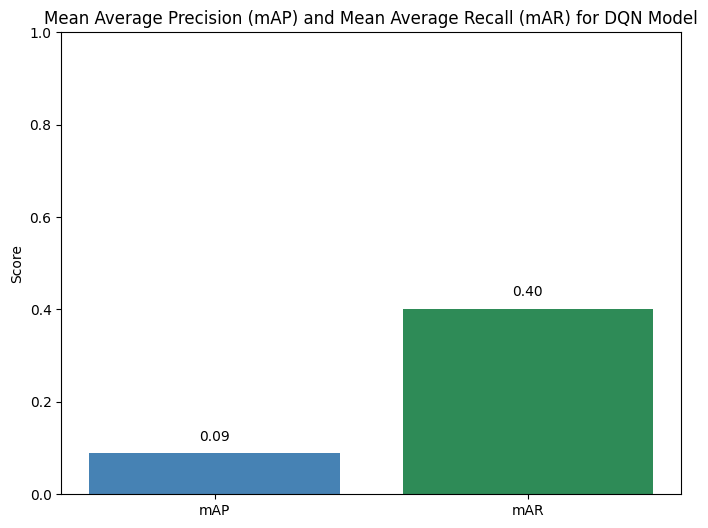

In [15]:
from sklearn.metrics import average_precision_score, recall_score

episode_AP = []
episode_recall = []
for result in all_episode_results:
    actual = result["actual"]
    predicted = result["predicted"]
    # Compute average precision (mAP for this episode)
    ap = average_precision_score(actual, predicted)
    # Compute recall (for this episode)
    rec = recall_score(actual, predicted)
    episode_AP.append(ap)
    episode_recall.append(rec)
mAP = np.mean(episode_AP)
mAR = np.mean(episode_recall)


plt.figure(figsize=(8,6))
bars = plt.bar(["mAP", "mAR"], [mAP, mAR], capsize=5, color=["steelblue", "seagreen"])
plt.ylim(0, 1)
plt.title("Mean Average Precision (mAP) and Mean Average Recall (mAR) for DQN Model")
plt.ylabel("Score")
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.02, f"{yval:.2f}", ha="center", va="bottom")
plt.show()

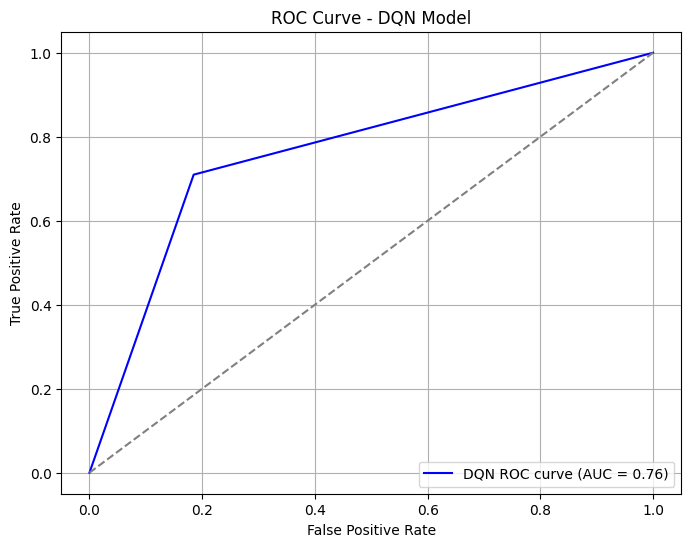

In [17]:
from sklearn.metrics import roc_curve, roc_auc_score

all_actual_dqn = []
all_predicted_dqn = []
for result in all_episode_results:
    all_actual_dqn.extend(result["actual"])
    all_predicted_dqn.extend(result["predicted"])

fpr_dqn, tpr_dqn, thresholds = roc_curve(all_actual_dqn, all_predicted_dqn)
roc_auc_dqn = roc_auc_score(all_actual_dqn, all_predicted_dqn)

plt.figure(figsize=(8, 6))
plt.plot(fpr_dqn, tpr_dqn, label=f"DQN ROC curve (AUC = {roc_auc_dqn:.2f})", color='blue')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - DQN Model")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

Note: you may need to restart the kernel to use updated packages.


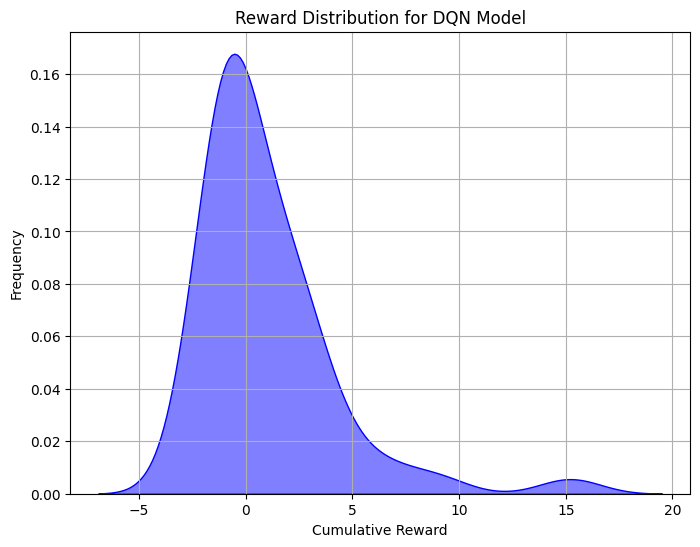

In [19]:
#plt.figure(figsize=(8,6))
%pip install seaborn
import seaborn as sns

fig, ax = plt.subplots(figsize=(8, 6))
sns.kdeplot(eval_rewards, ax=ax, fill=True, color='blue', alpha=0.5)
#plt.hist(eval_rewards, bins=20, edgecolor="black", alpha=0.75)
plt.xlabel("Cumulative Reward")
plt.ylabel("Frequency")
plt.title("Reward Distribution for DQN Model")
plt.grid(True)
plt.show()